# **Classification**

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast'

# Load Cleaned Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/BTCAugmented.csv", index_col='date', parse_dates=True))

print(df.shape)
df.head(5)

(2650, 18)


,open,high,low,close,Volume BTC,Volume USD,price mean,upper shadow,lower shadow,spread,trade,10 period SMA,50 period SMA,100 period SMA,12EMA,26EMA,MACD,buy/sell
date,,,,,,,,,,,,,,,,,,
2014-11-29,376.42,386.60,372.25,376.72,2746157.05,7245.19,377.9975,9.88,4.17,14.35,0.30,0.0,0.0,0.0,376.347692,376.312593,0.035100,1
2014-11-30,376.57,381.99,373.32,373.34,1145566.61,3046.33,376.3050,5.42,0.02,8.67,-3.23,0.0,0.0,0.0,375.884970,376.092401,-0.207430,0
2014-12-01,376.40,382.31,373.03,378.39,2520662.37,6660.56,377.5325,3.92,3.37,9.28,1.99,0.0,0.0,0.0,376.270360,376.262593,0.007766,1
2014-12-02,378.39,382.86,375.23,379.25,2593576.46,6832.53,378.9325,3.61,3.16,7.63,0.86,0.0,0.0,0.0,376.728766,376.483883,0.244883,1
2014-12-03,379.25,383.00,374.23,376.67,2998357.92,7908.29,378.2875,3.75,2.44,8.77,-2.58,0.0,0.0,0.0,376.719725,376.497669,0.222056,0


---

# Step 2: ML Pipeline with all data

ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine import transformation as vt

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ('numerical_transformation', vt.YeoJohnsonTransformer(variables=['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD', 
                         'price mean', 'upper shadow', 'lower shadow', 
                         'spread', '10 period SMA', '50 period SMA', 
                         '100 period SMA', '12EMA', '26EMA'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('numerical_transformation',
                 YeoJohnsonTransformer(variables=['open', 'high', 'low',
                                                  'close', 'Volume BTC',
                                                  'Volume USD', 'price mean',
                                                  'upper shadow',
                                                  'lower shadow', 'spread',
                                                  '10 period SMA',
                                                  '50 period SMA',
                                                  '100 period SMA', '12EMA',
                                                  '26EMA'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['buy/sell'], axis=1),
    df['buy/sell'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2120, 17) (2120,) (530, 17) (530,)


Handle Target Imbalance

In [9]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2120, 3) (2120,) (530, 3) (530,)


Check Train Set Target distribution

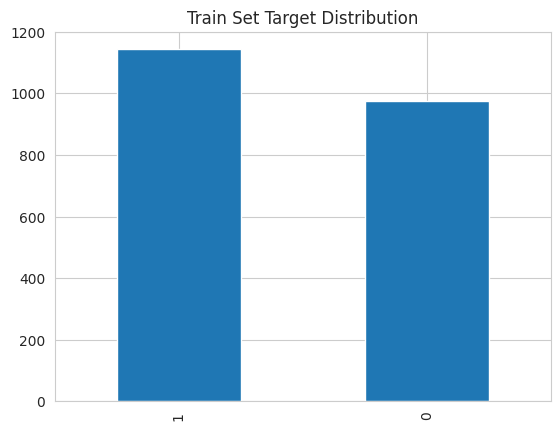

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [11]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2286, 3) (2286,) (530, 3) (530,)


Check Train Set Target distribution after resampling

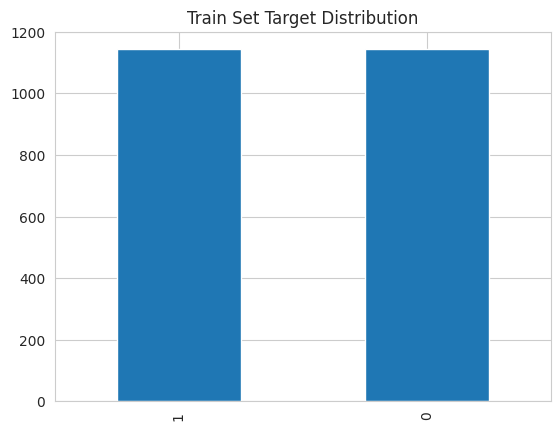

In [12]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

Use standard hyperparameters to find most suitable algorithm

In [13]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

Quick GridSearch CV - Binary Classifier

In [14]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,0.982533,0.991251,1.0,0.005524
1,XGBClassifier,0.969432,0.98426,0.991266,0.008089
6,AdaBoostClassifier,0.969432,0.981636,0.986842,0.006399
4,GradientBoostingClassifier,0.969432,0.979886,0.986842,0.005903
5,ExtraTreesClassifier,0.969432,0.979009,0.982533,0.005072
3,RandomForestClassifier,0.965066,0.978135,0.986842,0.007293
2,DecisionTreeClassifier,0.965066,0.974634,0.982456,0.005776


## Extensive search on the most suitable algorithm to find the best hyperparameter configuration.

In [16]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Define the models to search
models_search = { 
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
}

# Define hyperparameters for each model
params_search = {
    "LogisticRegression": {
        'model__C': [0.01, 0.1, 1, 10],  # Regularization parameter
        'model__penalty': ['l2'],  # Common penalty for logistic regression
        'model__solver': ['lbfgs']  # Standard solver, suitable for small to medium datasets
    },
    "XGBClassifier": {
        'model__learning_rate': [0.1, 0.01, 0.001],
        'model__max_depth': [3, 10, None],
        'model__n_estimators': [50, 100, 200]  # Number of trees
    }
}


Extensive GridSearch CV - Binary Classifier

In [17]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Check results

In [18]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__C,model__penalty,model__solver,model__learning_rate,model__max_depth,model__n_estimators
1,LogisticRegression,0.978166,0.992128,1.0,0.007512,0.1,l2,lbfgs,NaN,NaN,NaN
2,LogisticRegression,0.982533,0.991251,1.0,0.005524,1,l2,lbfgs,NaN,NaN,NaN
3,LogisticRegression,0.982533,0.989504,0.995633,0.004447,10,l2,lbfgs,NaN,NaN,NaN
4,XGBClassifier,0.973799,0.985134,0.991266,0.006525,NaN,NaN,NaN,0.1,3,50
5,XGBClassifier,0.973799,0.985134,0.991266,0.006525,NaN,NaN,NaN,0.1,3,100
6,XGBClassifier,0.973799,0.985134,0.991266,0.006525,NaN,NaN,NaN,0.1,3,200
15,XGBClassifier,0.969432,0.98426,0.991266,0.008089,NaN,NaN,NaN,0.01,3,200
24,XGBClassifier,0.969432,0.98426,0.991266,0.008089,NaN,NaN,NaN,0.001,3,200
21,XGBClassifier,0.969432,0.98426,0.991266,0.008089,NaN,NaN,NaN,0.01,None,200
22,XGBClassifier,0.969432,0.98426,0.991266,0.008089,NaN,NaN,NaN,0.001,3,50


Get best model name programmatically

In [19]:
best_model = grid_search_summary.iloc[0,0]
best_model

'LogisticRegression'

Parameters for best model

In [20]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

Define the best clf pipeline

In [21]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=LogisticRegression(random_state=0))),
                ('model', LogisticRegression(C=0.1, random_state=0))])

## Assess feature importance

In [22]:
X_train.head(3)

,Volume USD,trade,MACD
0,28.297683,130.95,-514.335331
1,31.710361,-1065.08,-29.981253
2,33.325335,-2045.20,-902.492367


In [24]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].coef_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

ValueError: Per-column arrays must each be 1-dimensional

Evaluate Pipeline on Train and Test Sets

In [25]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [27]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Sell', 'Buy'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                Actual Sell Actual Buy
Prediction Sell        1018          5
Prediction Buy          125       1138


---  Classification Report  ---
              precision    recall  f1-score   support

        Sell       1.00      0.89      0.94      1143
         Buy       0.90      1.00      0.95      1143

    accuracy                           0.94      2286
   macro avg       0.95      0.94      0.94      2286
weighted avg       0.95      0.94      0.94      2286
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual Sell Actual Buy
Prediction Sell         231          0
Prediction Buy           21        278


---  Classification Report  ---
              precision    recall  f1-score   support

        Sell       1.00      0.92      0.96       252
         Buy       0.93      1.00      0.96       278

    accuracy                           0.96       530
   macro avg       0.96      0.96      0.96       530
w

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
